In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Load data

In [2]:
with h5py.File('dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    
    # The indices of features that are observed in each dataset.
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)

# Preprocess the data
X = X.toarray()
X[batches[:,-1]!=2,:] = np.log(X[batches[:,-1]!=2,:]/np.sum(X[batches[:,-1]!=2,:], axis=1, keepdims=True)*1e4+1.)
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)
data = np.c_[X, Y]

# Subset the data, only use CITE-seq and ASAP-seq datasets for illustration.
batches = batches[sample_sizes[0]:]
data = data[sample_sizes[0]:]
sample_sizes = sample_sizes[1:]


gene_names = gene_names[id_X_cite] # remove genes not measured in the two datasets
id_Y_cite_val = np.random.choice(id_Y_cite, int(0.1*len(id_Y_cite)), replace=False)
id_Y_cite = np.setdiff1d(id_Y_cite, id_Y_cite_val)
dim_input_arr = np.array([len(gene_names),len(ADT_names)])

data = data[:, np.r_[id_X_cite, id_Y_asap+dim_input_arr[0]]]
data_raw = data.copy()


# The masks indicate missing pattern for the whole datasets.
masks_raw = - np.ones_like(data, dtype=np.float32)
masks_raw[:sample_sizes[0], :] = 0.
masks_raw[sample_sizes[0]:, dim_input_arr[0]:] = 0.

# randomly remove 20% of entries to be missing
# Each row corresponds to a cell, and each column corresponds to a feature.
# If the dataset is large, one can also provide a mask matrix with shape (num_datasets, num_features)
# along with a variable `id_datasets` to reduce memory usages.
# -1 means missing and 0 means observed.
masks = masks_raw.copy()
masks[np.random.rand(*masks.shape) < 0.2] = -1
data = data * (masks != -1)
masks = tf.convert_to_tensor(masks, dtype=tf.float32)

print('Sample sizes: {}. Feature sizes: {}.'.format(sample_sizes, dim_input_arr))

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
Sample sizes: [8689 8535]. Feature sizes: [2374  227].


# Set up config for model training

In [3]:
import sys; sys.path.insert(0, '..') # add parent folder path if not installed via PyPI
import scVAEIT
print(scVAEIT.__version__)

from scVAEIT import VAEIT

path_root = 'example/result/2/'

config = {
    # Dimension of input features for [RNA, ADT, peaks]
    'dim_input_arr': dim_input_arr,

    # Blocks for [RNA, ADT]
    'dim_block': np.array([len(gene_names),len(ADT_names)]), # input dimension of blocks
    'dist_block':['NB','NB'], # distributions of blocks
    'dim_block_enc':np.array([128, 64]), # dimension of first layer of the encoder
    'dim_block_dec':np.array([128, 64]), # dimension of first layer of the decoder
    'dim_block_embed':np.array([128, 64]), # mask embedding dimension

    # Internal network structure
    'dimensions':[32], # dimension of latent layers of encoder; the reversed is used for decoder
    'dim_latent':8, # the latent dimension bewteen the encoder and decoder

    # Weights
    'beta_unobs':.9, # weight for masked out observation; weight for observerd values will be 1-beta_unobs.
    'beta_modal':np.array([0.05,0.95]), # weights for 2 modalities, which can be adjusted based on loss in the first few epochs.

    # Masking probability
    "p_feat" : 0.5, # probablity of randomly masking out an entry
}

batches_cate = batches
batches_cont = None

model = VAEIT(config, data, masks, None, batches_cate, batches_cont)

1.0.0
namespace(beta_kl=2.0, beta_reverse=0.0, beta_modal=array([0.05, 0.95]), p_modal=None, uni_block_names=array(['M-0', 'M-1'], dtype='<U23'), block_names=array(['M-0', 'M-1'], dtype='<U23'), dist_block=array(['NB', 'NB'], dtype='<U2'), dim_block=array([2374,  227]), dim_block_enc=array([128,  64], dtype=int32), dim_block_dec=array([128,  64], dtype=int32), skip_conn=False, max_vals=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([8.987527 , 6.5821476], dtype=float32)>, gamma=0.0, dim_input_arr=array([2374,  227]), dim_block_embed=array([128,  64]), dimensions=array([32], dtype=int32), dim_latent=8, beta_unobs=0.9, p_feat=0.5) (17224, 2601) (17224, 2601) (17224, 2)


In [4]:
# Here we only train for 300 epochs for illustration purpose
hist = model.train(
        num_epoch=300, batch_size=256, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Deleting old log directory at example/result/2/checkpoint/
Train - Start of epoch 1
67/67 [==============================] - 5s 73ms/step - Reconstructed Loss: 121.7856
Epoch 1, Time elapsed: 0.08 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :  135.14,    6.19,   23.38,   52.83,   44.11,    8.63,    0.00
Train - Start of epoch 2
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 61.7058
Epoch 2, Time elapsed: 0.11 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   60.06,    3.76,    8.07,   31.43,   15.41,    1.38,    0.00
Train - Start of epoch 3
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 55.0988
Epoch 3, Time elapsed: 0.14 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   55.03,    3.71,    5.21,   31.00,   14.32,    0.79,    0.00
Train - Start of epoch 4
67/67 [==============================] - 2s 27ms

Train - Start of epoch 81
67/67 [==============================] - 2s 26ms/step - Reconstructed Loss: 47.5624
Epoch 81, Time elapsed: 2.55 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   47.44,    3.21,    4.05,   27.68,   12.22,    0.28,    0.00
Train - Start of epoch 82
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 47.8637
Epoch 82, Time elapsed: 2.59 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   47.72,    3.21,    4.04,   27.58,   12.60,    0.28,    0.00
Train - Start of epoch 83
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 48.1156
Epoch 83, Time elapsed: 2.62 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   47.23,    3.20,    4.03,   27.47,   12.24,    0.28,    0.00
Train - Start of epoch 84
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 47.4937
Epoch 84, Time el

train :   47.10,    3.19,    3.93,   27.46,   12.24,    0.28,    0.00
Train - Start of epoch 109
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 46.4314
Epoch 109, Time elapsed: 3.43 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   47.10,    3.19,    3.94,   27.40,   12.28,    0.29,    0.00
Train - Start of epoch 110
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 47.8359
Epoch 110, Time elapsed: 3.46 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.93,    3.19,    3.93,   27.38,   12.14,    0.29,    0.00
Train - Start of epoch 111
67/67 [==============================] - 2s 26ms/step - Reconstructed Loss: 46.0370
Epoch 111, Time elapsed: 3.49 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.94,    3.19,    3.93,   27.44,   12.11,    0.28,    0.00
Train - Start of epoch 112
67/67 [=================

train :   47.07,    3.18,    3.85,   27.38,   12.38,    0.28,    0.00
Train - Start of epoch 137
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 48.7762
Epoch 137, Time elapsed: 4.29 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.94,    3.18,    3.85,   27.41,   12.22,    0.28,    0.00
Train - Start of epoch 138
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 46.3509
Epoch 138, Time elapsed: 4.32 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   47.04,    3.18,    3.85,   27.37,   12.37,    0.27,    0.00
Train - Start of epoch 139
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 48.0789
Epoch 139, Time elapsed: 4.35 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.89,    3.18,    3.85,   27.35,   12.23,    0.28,    0.00
Train - Start of epoch 140
67/67 [=================

67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 47.2952
Epoch 164, Time elapsed: 5.14 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.76,    3.17,    3.78,   27.36,   12.16,    0.28,    0.00
Train - Start of epoch 165
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 48.2008
Epoch 165, Time elapsed: 5.17 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.86,    3.17,    3.78,   27.44,   12.19,    0.28,    0.00
Train - Start of epoch 166
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 45.4008
Epoch 166, Time elapsed: 5.2 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.82,    3.17,    3.77,   27.24,   12.36,    0.28,    0.00
Train - Start of epoch 167
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 46.5370
Epoch 167, Time elapsed: 5.23 minutes


67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 49.1976
Epoch 192, Time elapsed: 5.99 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.62,    3.17,    3.74,   27.39,   12.04,    0.28,    0.00
Train - Start of epoch 193
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 46.6809
Epoch 193, Time elapsed: 6.02 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.72,    3.17,    3.74,   27.46,   12.07,    0.28,    0.00
Train - Start of epoch 194
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 44.6498
Epoch 194, Time elapsed: 6.05 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.60,    3.17,    3.74,   27.35,   12.06,    0.29,    0.00
Train - Start of epoch 195
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 47.7137
Epoch 195, Time elapsed: 6.08 minutes

train :   46.46,    3.16,    3.69,   27.39,   11.93,    0.28,    0.00
Train - Start of epoch 220
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 45.5194
Epoch 220, Time elapsed: 6.87 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.49,    3.16,    3.69,   27.49,   11.88,    0.28,    0.00
Train - Start of epoch 221
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 48.2639
Epoch 221, Time elapsed: 6.9 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.47,    3.16,    3.69,   27.31,   12.03,    0.28,    0.00
Train - Start of epoch 222
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 44.7414
Epoch 222, Time elapsed: 6.93 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.68,    3.16,    3.69,   27.33,   12.21,    0.28,    0.00
Train - Start of epoch 223
67/67 [==================

train :   46.51,    3.16,    3.65,   27.34,   12.08,    0.28,    0.00
Train - Start of epoch 248
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 48.2300
Epoch 248, Time elapsed: 7.73 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.53,    3.16,    3.65,   27.43,   12.02,    0.28,    0.00
Train - Start of epoch 249
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 46.6429
Epoch 249, Time elapsed: 7.76 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.64,    3.16,    3.65,   27.38,   12.17,    0.28,    0.00
Train - Start of epoch 250
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 46.3817
Epoch 250, Time elapsed: 7.79 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.75,    3.16,    3.65,   27.16,   12.50,    0.28,    0.00
<tf.Variable 'Variable:0' shape=() dtype=int32, num

67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 46.3714
Epoch 275, Time elapsed: 8.58 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.64,    3.15,    3.62,   27.24,   12.34,    0.28,    0.00
Train - Start of epoch 276
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 46.5388
Epoch 276, Time elapsed: 8.61 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.41,    3.16,    3.63,   27.28,   12.06,    0.28,    0.00
Train - Start of epoch 277
67/67 [==============================] - 2s 28ms/step - Reconstructed Loss: 45.6495
Epoch 277, Time elapsed: 8.64 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   46.52,    3.16,    3.62,   27.33,   12.12,    0.28,    0.00
Train - Start of epoch 278
67/67 [==============================] - 2s 27ms/step - Reconstructed Loss: 45.3867
Epoch 278, Time elapsed: 8.67 minutes

We can visualize the training loss. It fluctuates since we argument the data with random masking, which also provides regularization against overfitting.
One may continue training until the loss gets stabilized.

Text(0, 0.5, 'Trianing loss')

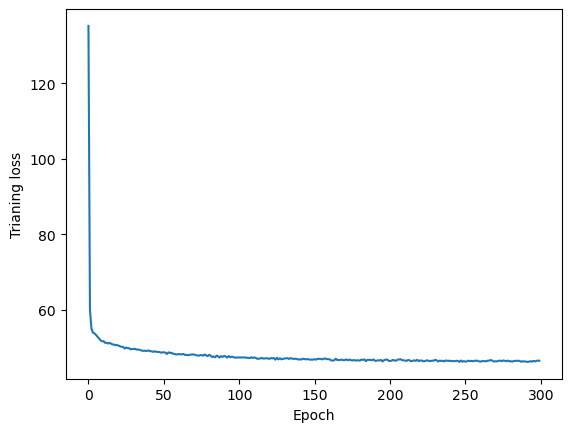

In [5]:
plt.plot(hist['train']['total'])
plt.xlabel('Epoch')
plt.ylabel('Trianing loss')

We can load the trained model:

```python
# load the model and ensure it is loaded successfully
checkpoint = tf.train.Checkpoint(net=model.vae)
n_ckpt = 6
status = checkpoint.restore(path_root+'checkpoint/ckpt-{}'.format(n_ckpt))
model.vae(tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.batches.shape[1]))), L=1, training=False)
print(status)
```

# Inspect imputation results

In [6]:
denoised_data = model.get_denoised_data()

Text(0, 0.5, 'Imputed')

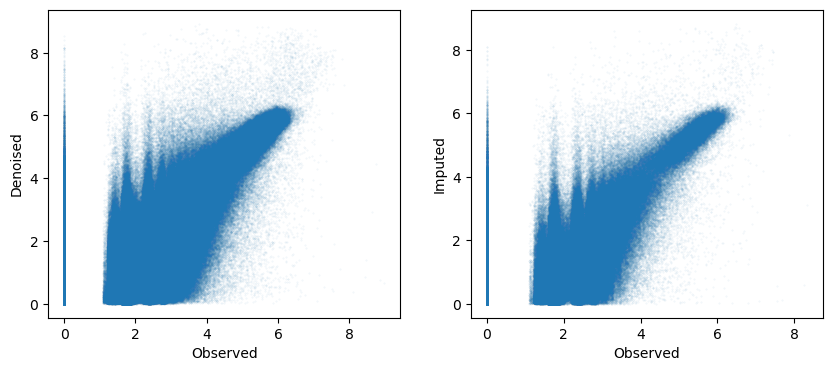

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(
    data_raw[masks==0],
    denoised_data[masks==0], s=0.1, alpha=0.1
    )
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Denoised')

axes[1].scatter(
    data_raw[(masks_raw==0)&(masks==-1)],
    denoised_data[(masks_raw==0)&(masks==-1)], s=0.1, alpha=0.1
    )
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Imputed')
plt.show()